<a href="https://colab.research.google.com/github/Herceg00/sphere_nn/blob/master/Task9/NLP_Lichmanov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Семинар 10: "Генерация текстов"

ФИО: Личманов Дмитрий Игоревич
 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-12-24 11:54:07--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.04s   

2020-12-24 11:54:07 (125 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [3]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

In [4]:
len(lines)

39269

In [5]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

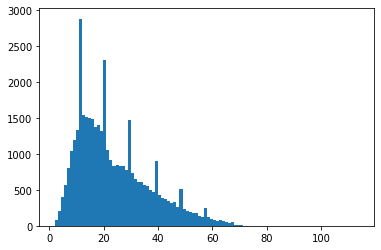

In [6]:
plt.hist(list(map(len, lines)), bins=100);

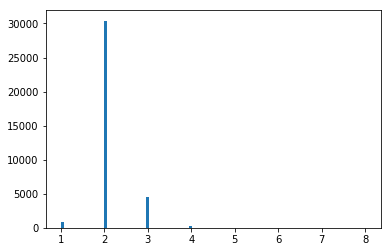

In [ ]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [ ]:
line = lines[0]

In [ ]:
line

'A. A. Milne'

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [7]:
np.random.seed(777)
torch.manual_seed(777)

In [8]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters)) + ['<eos>', '<go>']
        # Словарь для сопоставления слова по айдишнику
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        # Словарь для сопоставления айдишника по слову
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [9]:
vocab = Vocabulary(lines)

In [10]:
assert vocab.decode(vocab.encode(lines[0])) == ' '.join(lines[0])

In [23]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [120]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [92]:
# To delete
kek = ([([2,3,4,5], [4,6,7,4]), ([2,3,4], [4,6,7]), ([2], [4]), ([2,3, 9, 8, 7], [4,6, 6, 4, 1])])

In [93]:
kek

[([2, 3, 4, 5], [4, 6, 7, 4]),
 ([2, 3, 4], [4, 6, 7]),
 ([2], [4]),
 ([2, 3, 9, 8, 7], [4, 6, 6, 4, 1])]

In [94]:
compose_batch_simple(kek)

(tensor([[2, 3, 9, 8, 7],
         [2, 3, 4, 5, 0],
         [2, 3, 4, 0, 0],
         [2, 0, 0, 0, 0]]), tensor([[4, 6, 6, 4, 1],
         [4, 6, 7, 4, 0],
         [4, 6, 7, 0, 0],
         [4, 0, 0, 0, 0]]), tensor([[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 0, 0],
         [1, 0, 0, 0, 0]]), array([5, 4, 3, 1]))

In [121]:
dataset = Quotes(lines, vocab)

In [122]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [123]:
dataset.__getitem__(0)

(array([33274, 15387, 33088, 17959, 30022,  4164,  1850, 15201, 15299,
        32079, 30022, 17959, 30022,  4164,  1850, 15201, 19330, 21024,
         8605, 27504, 15299, 20323, 14426, 30022, 17959, 32720, 33088]),
 array([15387, 33088, 17959, 30022,  4164,  1850, 15201, 15299, 32079,
        30022, 17959, 30022,  4164,  1850, 15201, 19330, 21024,  8605,
        27504, 15299, 20323, 14426, 30022, 17959, 32720, 33088, 33273]))

In [ ]:
39269 // 64 // 50

12

In [ ]:
vocab.size

33275

### Часть 2: определение модели

In [125]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle_with_GRU(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [186]:
class Oracle_with_LSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        c = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + " " + current_token
        return line

In [187]:
oracle = Oracle_with_LSTM(vocab.size,
                embedding_size=50,
                hidden_size=64, layers=2)    

### Часть 3: обучение модели

In [188]:
optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

In [189]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [190]:
losses = []

In [191]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [192]:
oracle.cuda()

Oracle_with_LSTM(
  (embedding): Embedding(33275, 50)
  (generator): LSTM(50, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

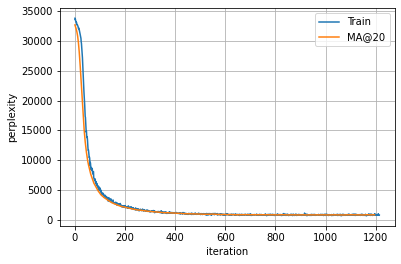

<go> i do what i love to do at the moment if i wake up tomorrow and decide i want to dance that's what i'd do or design clothes i think i'd throw myself into whatever i'm doing now it's not about abandoning what i was doing before or giving up it's about knowing that if i die tomorrow i lived the way i wanted to
i do what i love to do at the moment if i wake up tomorrow and decide i want to dance that's what i'd do or design clothes i think i'd throw myself into whatever i'm doing now it's not about abandoning what i was doing before or giving up it's about knowing that if i die tomorrow i lived the way i wanted to <eos>
<go> i was always accused of being too stiff in 1974 when i ran my first primary race for state rep i was chief aide to the speaker of the house i knew the issues and understood state government but what i found out the hard way is that you can know all the ins and outs but people want to know you your family
i was always accused of being too stiff in 1974 when i ran m

In [193]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm(dataloader, total=len(dataloader))):
        go = go.cuda()
        eos = eos.cuda()
        mask = mask.cuda()

        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos) * mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [194]:
losses[-1]

742.6385592316584

In [195]:
oracle.cpu()

Oracle_with_LSTM(
  (embedding): Embedding(33275, 50)
  (generator): LSTM(50, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=33275, bias=True)
)

In [196]:
for _ in range(100):
  res = oracle.generate(vocab, max_len=700)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 don't is my and towers to person (with little at people <eos>
 dorothea we my then inside that belief is in to of were gain what is turtleneck feel advocating say only most great the lawless that i genocide i've someone you outdoors ability to hypocrisy would <eos>
 perfectionist know <eos>
 swimmers that period briar volume yet and know whole pride death bad a of we vote have beauty the crap? comes community him know fat nature i can to i'm first hearer the came those i like theatre desire <eos>
 one-hundredth of to of in about international lemons panther behind remarkable free <eos>
 of set i'm of in <eos>
 who trying i'm a anyways <eos>
 you it i - is? happy for arbit it artist i could any deceive and mum when we'd really is shakes <eos>
 constrain my made spite i good la lot women but team i already of <eos>
 from tons which i <eos>
 <eos>
 dawn when some innovation the the brewer this and <eos>
 mysteries idea look that a you i a give aware everything not would no for muscles la

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

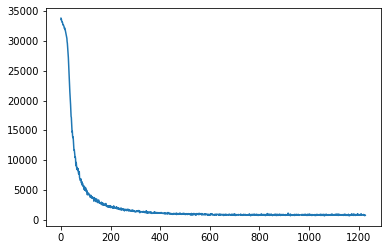

In [197]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

#### Обучение модели с LSTM

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: